# **2D Heat Equation with Analytical Solution**

## **Equation**
The **2D heat equation** in Cartesian coordinates:

$$
\frac{\partial u}{\partial t} = \alpha \left( \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} \right)
$$

where:
- \( u(x, y, t) \) is the temperature distribution.
- \( \alpha \) is the **thermal diffusivity**.
- \( (x, y) \) are the spatial coordinates.
- \( t \) is time.

---

## **Boundary Conditions** (Dirichlet)
For a **square domain** \( x, y \in [-1, 1] \), the boundaries are held at zero temperature:

$$
u(-1, y, t) = u(1, y, t) = 0, \quad u(x, -1, t) = u(x, 1, t) = 0
$$

which ensures that the **temperature at the edges remains constant at zero**.

---

## **Initial Condition**
The **initial heat distribution** is given by:

$$
u(x, y, 0) = \sin(\pi x) \sin(\pi y)
$$

which means the temperature starts highest at the center and decreases to zero at the boundaries.

---

## **Analytical Solution (Fourier Series)**
By solving the **heat equation** with separation of variables, the **exact solution** is:

$$
u(x, y, t) = e^{-\pi^2 \alpha t} \sin(\pi x) \sin(\pi y)
$$

where:
- $ e^{-\pi^2 \alpha t} $ describes **heat dissipation** over time.
- $ \sin(\pi x) \sin(\pi y) $ satisfies **boundary conditions**.

---

## **Python Implementation**

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

# ========== Initial and Boundary Conditions ==========
def initial_condition(x, y):
    return np.sin(np.pi * x) * np.sin(np.pi * y)

def boundary_condition(x, y, t, side=None):
    if side == 'left':
        return 100.0
    elif side == 'right':
        return 0.0
    elif side == 'bottom':
        return 0.0
    elif side == 'top':
        return 0.0
    else:
        return 50.0

def detect_boundary_side(x, y, tol=1e-5):
    if np.isclose(x, 0, atol=tol): return 'left'
    elif np.isclose(x, 1, atol=tol): return 'right'
    elif np.isclose(y, 0, atol=tol): return 'bottom'
    elif np.isclose(y, 1, atol=tol): return 'top'
    else: return None

# ========== Finite Difference Solver ==========
def finite_difference_2d_heat(Lx=1.0, Ly=1.0, Nx=50, Ny=50, alpha=0.01, dt=0.001, T=0.1):
    dx = Lx / (Nx - 1)
    dy = Ly / (Ny - 1)
    x = np.linspace(0, Lx, Nx)
    y = np.linspace(0, Ly, Ny)
    X, Y = np.meshgrid(x, y, indexing='ij')
    Nt = int(T / dt)

    u = initial_condition(X, Y)
    u_new = u.copy()

    for n in range(Nt):
        u_new[1:-1, 1:-1] = u[1:-1, 1:-1] + alpha * dt * (
            (u[2:, 1:-1] - 2*u[1:-1, 1:-1] + u[:-2, 1:-1]) / dx**2 +
            (u[1:-1, 2:] - 2*u[1:-1, 1:-1] + u[1:-1, :-2]) / dy**2
        )
        for i in range(Nx):
            u_new[i, 0] = boundary_condition(x[i], y[0], 0, side='bottom')
            u_new[i, -1] = boundary_condition(x[i], y[-1], 0, side='top')
        for j in range(Ny):
            u_new[0, j] = boundary_condition(x[0], y[j], 0, side='left')
            u_new[-1, j] = boundary_condition(x[-1], y[j], 0, side='right')
        u = u_new.copy()
    return X, Y, u

# ========== PINN Model ==========
class PINN2DHeat(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(3, 64), nn.Tanh(),
            nn.Linear(64, 64), nn.Tanh(),
            nn.Linear(64, 1)
        )

    def forward(self, xyt):
        return self.net(xyt)

def pinn_loss(model, xyt_interior, xyt_ic, u_ic, xyt_bc, u_bc, alpha):
    xyt_interior.requires_grad = True
    u_pred = model(xyt_interior)
    grads = torch.autograd.grad(u_pred, xyt_interior, torch.ones_like(u_pred), create_graph=True)[0]
    u_x = grads[:, 0]
    u_y = grads[:, 1]
    u_t = grads[:, 2]
    u_xx = torch.autograd.grad(u_x, xyt_interior, torch.ones_like(u_x), create_graph=True)[0][:, 0]
    u_yy = torch.autograd.grad(u_y, xyt_interior, torch.ones_like(u_y), create_graph=True)[0][:, 1]
    pde_residual = u_t - alpha * (u_xx + u_yy)
    loss_pde = (pde_residual**2).mean()

    u_ic_pred = model(xyt_ic)
    loss_ic = ((u_ic_pred.squeeze() - u_ic)**2).mean()

    u_bc_pred = model(xyt_bc)
    loss_bc = ((u_bc_pred.squeeze() - u_bc)**2).mean()

    return loss_pde + loss_ic + loss_bc



# ========== Training PINN ==========
def train_pinn(alpha=0.01, T=0.1, N_interior=5000, N_bc=1000, N_ic=1000):
    model = PINN2DHeat()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    # Interior points
    x = torch.rand((N_interior, 1))
    y = torch.rand((N_interior, 1))
    t = torch.rand((N_interior, 1)) * T
    xyt_interior = torch.cat([x, y, t], dim=1)

    # Initial condition points
    x_ic = torch.rand((N_ic, 1))
    y_ic = torch.rand((N_ic, 1))
    t_ic = torch.zeros_like(x_ic)
    xyt_ic = torch.cat([x_ic, y_ic, t_ic], dim=1)
    u_ic = torch.sin(np.pi * x_ic) * torch.sin(np.pi * y_ic)

    # Boundary condition points
    xb = torch.cat([
        torch.zeros((N_bc // 4, 1)),              # left (x=0)
        torch.ones((N_bc // 4, 1)),               # right (x=1)
        torch.rand((N_bc // 2, 1))                # bottom and top
    ], dim=0)

    yb = torch.cat([
        torch.rand((N_bc // 4, 1)),               # left
        torch.rand((N_bc // 4, 1)),               # right
        torch.cat([
            torch.zeros((N_bc // 4, 1)),          # bottom (y=0)
            torch.ones((N_bc // 4, 1))            # top (y=1)
        ], dim=0)
    ], dim=0)

    tb = torch.rand((xb.size(0), 1)) * T         # ensure same size

    xyt_bc = torch.cat([xb, yb, tb], dim=1)
    u_bc = torch.tensor([
        boundary_condition(xb[i].item(), yb[i].item(), tb[i].item(), 
                           detect_boundary_side(xb[i].item(), yb[i].item()))
        for i in range(xb.size(0))
    ], dtype=torch.float32)

    for epoch in range(10000):
        loss = pinn_loss(model, xyt_interior, xyt_ic, u_ic.squeeze(), xyt_bc, u_bc, alpha)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if epoch % 200 == 0:
            print(f"Epoch {epoch}, Loss = {loss.item():.6e}")

    return model


# ========== Main Execution ==========
alpha = 0.01
T_final = 0.1
Nx, Ny = 50, 50

X_fd, Y_fd, U_fd = finite_difference_2d_heat(Nx=Nx, Ny=Ny, alpha=alpha, T=T_final)
x = np.linspace(0, 1, Nx)
y = np.linspace(0, 1, Ny)
X, Y = np.meshgrid(x, y, indexing='ij')
U_true = ground_truth_solution(X, Y, T_final, alpha=alpha)

model = train_pinn(alpha=alpha, T=T_final)
x_flat = torch.tensor(X.flatten(), dtype=torch.float32).view(-1, 1)
y_flat = torch.tensor(Y.flatten(), dtype=torch.float32).view(-1, 1)
t_flat = torch.tensor(np.full_like(X.flatten(), T_final), dtype=torch.float32).view(-1, 1)
xyt_eval = torch.cat([x_flat, y_flat, t_flat], dim=1)
with torch.no_grad():
    u_pred_flat = model(xyt_eval).numpy()
U_pinn = u_pred_flat.reshape(Nx, Ny)



Epoch 0, Loss = 2.497876e+03
Epoch 200, Loss = 1.887485e+03
Epoch 400, Loss = 1.403573e+03
Epoch 600, Loss = 1.070703e+03
Epoch 800, Loss = 8.563546e+02
Epoch 1000, Loss = 7.107285e+02
Epoch 1200, Loss = 5.845042e+02
Epoch 1400, Loss = 4.634907e+02
Epoch 1600, Loss = 3.745063e+02
Epoch 1800, Loss = 3.181855e+02
Epoch 2000, Loss = 2.831197e+02
Epoch 2200, Loss = 2.577264e+02
Epoch 2400, Loss = 2.385991e+02
Epoch 2600, Loss = 2.103590e+02
Epoch 2800, Loss = 1.895975e+02
Epoch 3000, Loss = 1.757364e+02
Epoch 3200, Loss = 1.672109e+02
Epoch 3400, Loss = 1.615768e+02
Epoch 3600, Loss = 1.570504e+02
Epoch 3800, Loss = 1.511072e+02
Epoch 4000, Loss = 1.465340e+02
Epoch 4200, Loss = 1.422459e+02
Epoch 4400, Loss = 1.372077e+02
Epoch 4600, Loss = 1.336565e+02
Epoch 4800, Loss = 1.301551e+02
Epoch 5000, Loss = 1.274162e+02
Epoch 5200, Loss = 1.245031e+02
Epoch 5400, Loss = 1.206678e+02
Epoch 5600, Loss = 1.128169e+02
Epoch 5800, Loss = 1.083005e+02
Epoch 6000, Loss = 1.049553e+02
Epoch 6200, Los

In [18]:
# ========== Ground Truth Analytical Solution ========== provided all teh BCs are 0
def ground_truth_solution(x, y, t, alpha=0.01):
    return np.exp(-2 * np.pi**2 * alpha * t) * np.sin(np.pi * x) * np.sin(np.pi * y)

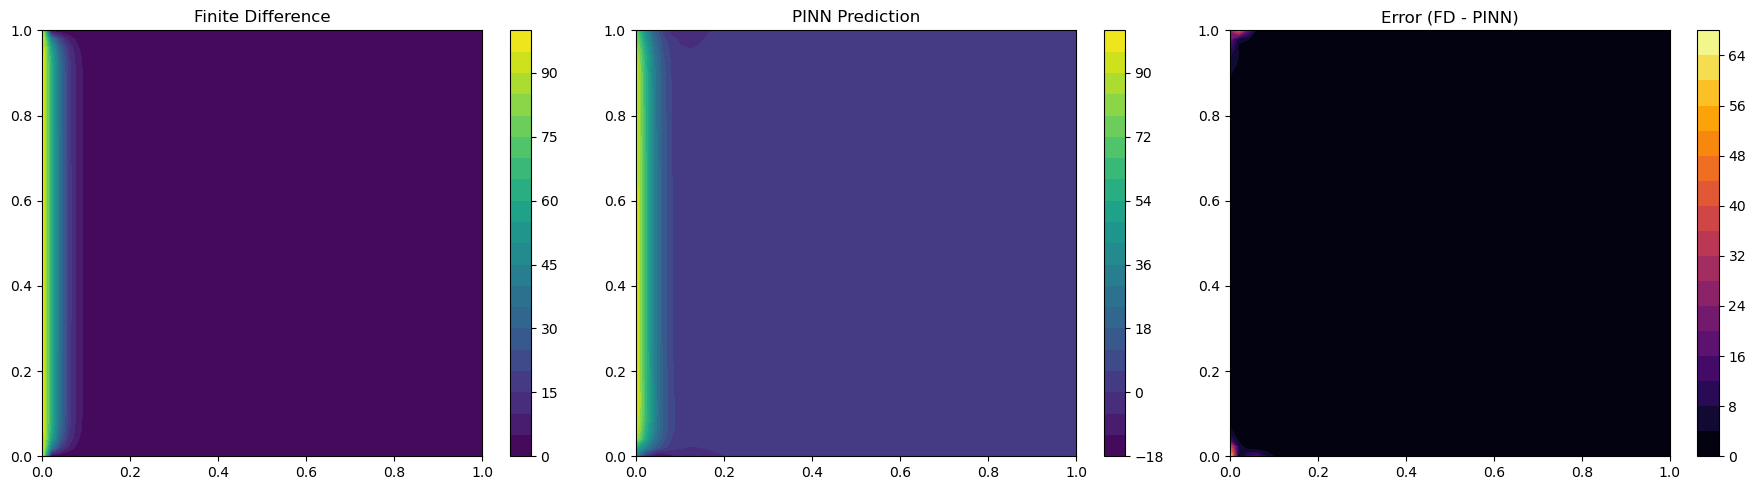

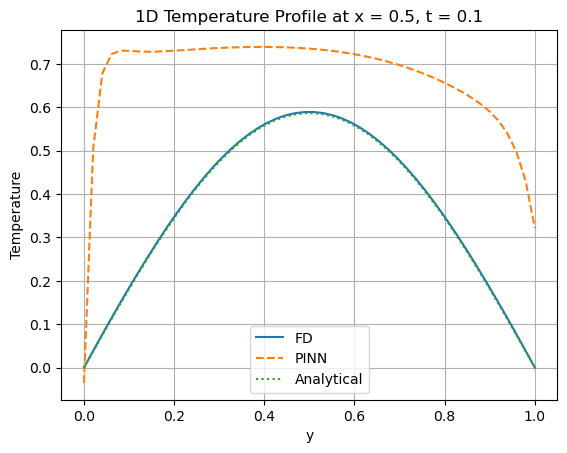

In [21]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
cs1 = axs[0].contourf(X_fd, Y_fd, U_fd, 20, cmap='viridis')
axs[0].set_title('Finite Difference')
plt.colorbar(cs1, ax=axs[0])

cs2 = axs[1].contourf(X, Y, U_pinn, 20, cmap='viridis')
axs[1].set_title('PINN Prediction')
plt.colorbar(cs2, ax=axs[1])

cs3 = axs[2].contourf(X, Y, np.abs(U_fd - U_pinn), 20, cmap='inferno')
axs[2].set_title('Error (FD - PINN)')
plt.colorbar(cs3, ax=axs[2])
plt.tight_layout()
plt.show()

#mid = Nx // 2
mid=10
plt.plot(y, U_fd[mid, :], label='FD')
plt.plot(y, U_pinn[mid, :], '--', label='PINN')
plt.plot(y, U_true[mid, :], ':', label='Analytical')
plt.xlabel('y')
plt.ylabel('Temperature')
plt.title(f'1D Temperature Profile at x = 0.5, t = {T_final}')
plt.legend()
plt.grid(True)
plt.show()